# Comparing GBM performance

There are multiple libraries for using gradient boosting machines. Here we simulate a supervised machine learning problem, fit some models and make some predictions.

First lets create a dummy dataset

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000,
    n_features=60,
    n_informative=15,
    n_redundant=45,
    random_state=42,
    flip_y=0.2,
)

Time the fitting of a standard model

Different parameters mean different model sizes, means different inference sizes. We need to fit a similar sized model in each case.

In [2]:
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import timeit
from sklearn.metrics import roc_auc_score

# GBM trees parameters
params = {
    "n_estimators": 100,  # Number of trees
    "learning_rate": 0.1,  # Learning rate
    "max_depth": 6,  # Maximum depth of trees
}

# Initialize models with shared parameters
models = {
    "HistGradientBoosting": lambda: HistGradientBoostingClassifier(
        max_iter=params["n_estimators"]
    ),
    "XGBoost": lambda: xgb.XGBClassifier(
        n_estimators=params["n_estimators"],
        learning_rate=params["learning_rate"],
        max_depth=params["max_depth"],
        eval_metric="logloss",
    ),
    "LightGBM": lambda: lgb.LGBMClassifier(
        n_estimators=params["n_estimators"],
        learning_rate=params["learning_rate"],
        max_depth=params["max_depth"],
        verbosity=-1,
    ),
}


# Dictionaries to store results
train_times = []
inference_times = []
performance = []
n_trials = 10


# Training and evaluation
for name, model_fcn in models.items():
    for t in range(n_trials):
        print(name, t)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=t
        )

        # Measure training time
        model = model_fcn()
        start_train = timeit.default_timer()
        model.fit(X_train, y_train)
        end_train = timeit.default_timer()
        train_times.append(
            {"model": name, "t": t, "train_time": end_train - start_train}
        )

        # Measure inference time
        for row in range(10):  # Repeat predictions 10 times to average inference time
            start_inference = timeit.default_timer()
            _ = model.predict(X_test[[row]])
            end_inference = timeit.default_timer()
            inference_times.append(
                {
                    "model": name,
                    "t": t,
                    "row": row,
                    "inference_time": end_inference - start_inference,
                }
            )

        # Calculate accuracy
        y_pred = model.predict(X_test)
        performance.append(
            {
                "model": name,
                "t": t,
                "auc_score": roc_auc_score(y_test, y_pred),
            }
        )

HistGradientBoosting 0
HistGradientBoosting 1
HistGradientBoosting 2
HistGradientBoosting 3
HistGradientBoosting 4
HistGradientBoosting 5
HistGradientBoosting 6
HistGradientBoosting 7
HistGradientBoosting 8
HistGradientBoosting 9
XGBoost 0
XGBoost 1
XGBoost 2
XGBoost 3
XGBoost 4
XGBoost 5
XGBoost 6
XGBoost 7
XGBoost 8
XGBoost 9
LightGBM 0
LightGBM 1
LightGBM 2
LightGBM 3
LightGBM 4
LightGBM 5
LightGBM 6
LightGBM 7
LightGBM 8
LightGBM 9


## Results

In [3]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

### Train times

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_38296/2634255285.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


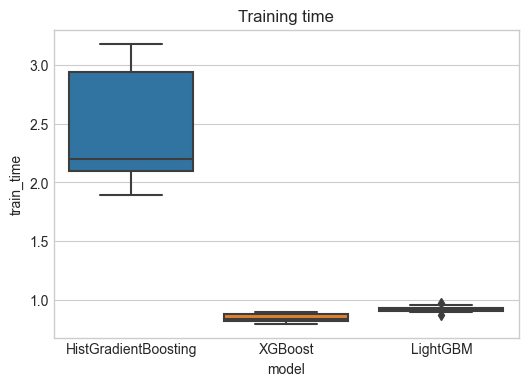

In [4]:
train_times_df = pl.DataFrame(train_times)
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(
    data=train_times_df.to_pandas(),
    x="model",
    y="train_time",
    ax=ax,
)
ax.set(title="Training time")
fig.show()

### Model performance

Given similar parameters we would expect a similar performance across models.

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_38296/1821014791.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


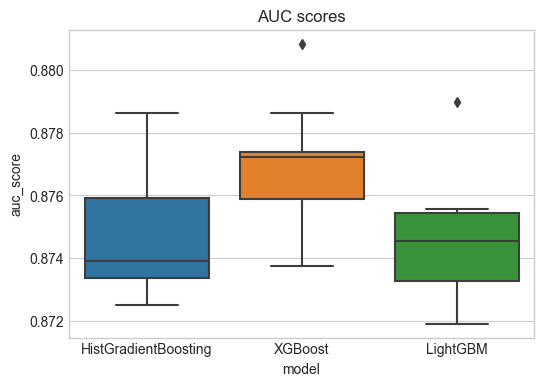

In [5]:
performance_df = pl.DataFrame(performance)
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(
    data=performance_df.to_pandas(),
    x="model",
    y="auc_score",
    ax=ax,
)
ax.set(title="AUC scores")
fig.show()

### Inference time

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_38296/2892260462.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


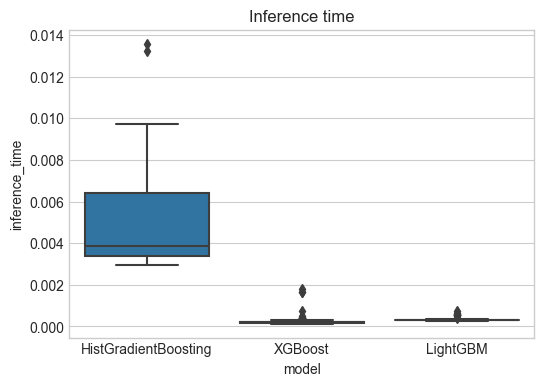

In [6]:
inference_times_df = pl.DataFrame(inference_times)
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(
    data=inference_times_df.to_pandas(),
    x="model",
    y="inference_time",
    ax=ax,
)
ax.set(title="Inference time")
fig.show()

## Conclusion

In this scenario XGBoost and LightGBM were very similar. Sklearn was slower on both by some margin.